In [1]:
# 패키지 로드
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm import tqdm as tq
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os, random

from scipy import sparse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F


import plotnine
from plotnine import *


In [2]:
# 하이퍼파라미터 
class cfg: 
    gpu_idx = 0
    device = torch.device("cuda:{}".format(gpu_idx) if torch.cuda.is_available() else "cpu")
    top_k = 25
    seed = 42
    # neg_ratio = 100
    neg_ratio = 125
    test_size = 0.2
# 시드 고정 
def seed_everything(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
seed_everything(cfg.seed)
# 경로 설정
data_path = '../data'
saved_path = './saved'
output_path = './submission'

In [3]:
# 데이터 불러오기 
history_df = pd.read_csv(os.path.join(data_path, 'history_data.csv'), encoding='utf-8')
profile_df = pd.read_csv(os.path.join(data_path, 'profile_data.csv'), encoding='utf-8')
meta_df = pd.read_csv(os.path.join(data_path, 'meta_data.csv'), encoding='utf-8')

watch_df=pd.read_csv(os.path.join(data_path, 'watch_e_data.csv'), encoding='utf-8')
buy_df=pd.read_csv(os.path.join(data_path, 'buy_data.csv'), encoding='utf-8')
search_df=pd.read_csv(os.path.join(data_path, 'search_data.csv'), encoding='utf-8')

In [4]:
# 데이터 전처리 (중복제거) 
# 참고 : drop_duplicates의 subset을 무엇으로 구성하냐에 따라서 제거되는 항목들이 다름 
# ex) 'profile_id', 'album_id' : 중복된 시청이력 모두 제거 / 'profile_id', 'album_id', 'log_time' : 같은 시간에 시청한 이력만 제거 
data = history_df[['profile_id', 'log_time', 'album_id']].drop_duplicates(subset=['profile_id', 'album_id', 'log_time']).sort_values(by = ['profile_id', 'log_time']).reset_index(drop = True)
data['rating'] = 1

cfg.n_users = data.profile_id.max()+1 
cfg.n_items = data.album_id.max()+1

# 학습 및 검증 데이터 분리
train, valid = train_test_split(
    data, test_size=cfg.test_size, random_state=cfg.seed,
)
print('학습 데이터 크기:', train.shape)
print('검증 데이터 크기:', valid.shape)

# Matrix 형태로 변환 
train = train.to_numpy()
matrix = sparse.lil_matrix((cfg.n_users, cfg.n_items))
for (p, _, i, r) in tq(train):
    # matrix[p, i] += r #시청 횟수 고려하는 방법

    matrix[p, i] = r # 문제점 1.시청 횟수를 고려못하고 무조건 다 1로 초기화 이러면 무슨의미가 있나..
    
train = sparse.csr_matrix(matrix)
train = train.toarray()
print("train 형태: \n", train)

# 유저 특징 정보 추출 
profile_df = profile_df.set_index('profile_id')
user_features = profile_df[['age']].to_dict()

le = LabelEncoder()
profile_df['sex'] = le.fit_transform(profile_df['sex'])
user_features_sex = profile_df[['sex']].to_dict()

le = LabelEncoder()
profile_df['pr_interest_keyword_cd_1'] = le.fit_transform(profile_df['pr_interest_keyword_cd_1'])
user_features_pr = profile_df[['pr_interest_keyword_cd_1']].to_dict()

le = LabelEncoder()
profile_df['ch_interest_keyword_cd_1'] = le.fit_transform(profile_df['ch_interest_keyword_cd_1'])
user_features_ch = profile_df[['ch_interest_keyword_cd_1']].to_dict()


print("user_id 3의 age 정보 :", user_features['age'][3])

# 아이템 특징 정보 추출 
meta_df = meta_df.set_index('album_id')

# 범주형 데이터를 수치형 데이터로 변경 
le = LabelEncoder()
meta_df['genre_mid'] = le.fit_transform(meta_df['genre_mid'])
item_features = meta_df[['genre_mid']].to_dict()
print("album_id 749의 genre_mid 정보 :", item_features['genre_mid'][749])

# 추출한 특징 정보의 속성을 저장 
cfg.n_genres = meta_df['genre_mid'].nunique()
cfg.n_sex = profile_df['sex'].nunique()
cfg.n_pr = profile_df['pr_interest_keyword_cd_1'].nunique()
cfg.n_ch = profile_df['ch_interest_keyword_cd_1'].nunique()
cfg.n_continuous_feats = 1 

학습 데이터 크기: (719401, 4)
검증 데이터 크기: (179851, 4)


100%|██████████| 719401/719401 [00:02<00:00, 310948.51it/s]


train 형태: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
user_id 3의 age 정보 : 5
album_id 749의 genre_mid 정보 : 1


In [5]:
class NeuMF(nn.Module):
    """Neural Matrix Factorization Model
        참고 문헌 : https://arxiv.org/abs/1708.05031

    예시 :
        model = NeuMF(cfg) 
        output = model.forward(user_ids, item_ids, [feat0, feat1]) 
    """
    def __init__(self, cfg):
        """ 
        Args:
            cfg : config 파일로 네트워크 생성에 필요한 정보들을 담고 있음 
        """
        super(NeuMF, self).__init__()
        self.n_users = cfg.n_users
        self.n_items = cfg.n_items
        self.emb_dim = cfg.emb_dim
        self.layer_dim = cfg.layer_dim
        self.n_continuous_feats = cfg.n_continuous_feats
        self.n_genres = cfg.n_genres
        self.n_sex = cfg.n_sex
        self.n_pr = cfg.n_pr
        self.n_ch = cfg.n_ch
        self.dropout = cfg.dropout
        self.build_graph()

    def build_graph(self):
        """Neural Matrix Factorization Model 생성
            구현된 모습은 위의 그림을 참고 
        """
        self.user_embedding_mf = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)
        self.item_embedding_mf = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)
        
        self.user_embedding_mlp = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)
        self.item_embedding_mlp = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)
                
        self.genre_embeddig = nn.Embedding(num_embeddings=self.n_genres, embedding_dim=self.n_genres//2)
        self.sex_embeddig = nn.Embedding(num_embeddings=self.n_sex, embedding_dim=self.n_sex)
        self.pr_embeddig = nn.Embedding(num_embeddings=self.n_pr, embedding_dim=self.n_pr)
        self.ch_embeddig = nn.Embedding(num_embeddings=self.n_ch, embedding_dim=self.n_ch)
        
        # self.mlp_layers = nn.Sequential(
        #     nn.Linear(2*self.emb_dim + self.n_genres//2 + self.n_continuous_feats, self.layer_dim),
        #     nn.BatchNorm1d(num_features=self.layer_dim), 
        #     nn.ReLU(), 
        #     nn.Dropout(p=self.dropout), 
        #     nn.Linear(self.layer_dim, self.layer_dim//2),
        #     nn.BatchNorm1d(num_features=self.layer_dim//2),  
        #     nn.ReLU(), 
        #     nn.Dropout(p=self.dropout),

        #     nn.Linear(self.layer_dim//2, self.layer_dim),
        #     nn.BatchNorm1d(num_features=self.layer_dim),  
        #     nn.ReLU(), 
        #     nn.Dropout(p=self.dropout),

        #     nn.Linear(self.layer_dim, self.layer_dim//2), 
        #     nn.BatchNorm1d(num_features=self.layer_dim//2), 
        #     nn.ReLU(), 
        #     nn.Dropout(p=self.dropout),

        #     nn.Linear(self.layer_dim//2, self.layer_dim//2), 
        #     nn.BatchNorm1d(num_features=self.layer_dim//2), 
        #     nn.ReLU(), 
        #     nn.Dropout(p=self.dropout)
        # )
        self.mlp_layers = nn.Sequential(
            nn.Linear(2*self.emb_dim + self.n_genres//2 +self.n_sex+self.n_ch+self.n_pr+ self.n_continuous_feats, self.layer_dim),
            nn.BatchNorm1d(num_features=self.layer_dim), 
            nn.ReLU(), 
            nn.Dropout(p=self.dropout), 
            nn.Linear(self.layer_dim, self.layer_dim//2),
            nn.BatchNorm1d(num_features=self.layer_dim//2),  
            nn.ReLU(), 
            nn.Dropout(p=self.dropout),

            nn.Linear(self.layer_dim//2, self.layer_dim),
            nn.BatchNorm1d(num_features=self.layer_dim),  
            nn.ReLU(), 
            nn.Dropout(p=self.dropout),

            nn.Linear(self.layer_dim, self.layer_dim//2), 
            nn.BatchNorm1d(num_features=self.layer_dim//2), 
            nn.ReLU(), 
            nn.Dropout(p=self.dropout),

            nn.Linear(self.layer_dim//2, self.layer_dim//2), 
            nn.BatchNorm1d(num_features=self.layer_dim//2), 
            nn.ReLU(), 
            nn.Dropout(p=self.dropout)
        )
        self.affine_wide_output = nn.Linear(self.layer_dim, 1)
        self.affine_deep_output = nn.Linear(self.layer_dim//2, 1)
        # self.affine_output = nn.Linear(self.layer_dim//2 + self.emb_dim, 1)
        self.apply(self._init_weights)
        

    def _init_weights(self, module):
        if isinstance(module, nn.Embedding):
            normal_(module.weight.data, mean=0.0, std=0.01)
        elif isinstance(module, nn.Linear):
            normal_(module.weight.data, 0, 0.01)
            if module.bias is not None:
                module.bias.data.fill_(0.0)
    
    def forward(self, user_indices, item_indices, feats):
        """ 
        Args:
            user_indices : 유저의 인덱스 정보 
                ex) tensor([ 3100,  3100,  ..., 14195, 14195])
            item_indices : 아이템의 인덱스 정보
                ex) tensor([   50,    65,   ..., 14960, 11527])
            feats : 특징 정보 
        Returns: 
            output : 유저-아이템 쌍에 대한 추천 결과 
                ex) tensor([  9.4966,  22.0261, ..., -19.3535, -23.0212])
        """
        
        
        out=self.affine_wide_output(torch.mul(self.user_embedding_mf(user_indices), self.item_embedding_mf(item_indices))).squeeze(-1)
        
        out+=self.affine_deep_output(self.mlp_layers(torch.cat((self.user_embedding_mlp(user_indices), self.item_embedding_mlp(item_indices), self.genre_embeddig(feats[1]),self.sex_embeddig(feats[2]),self.pr_embeddig(feats[3]),self.ch_embeddig(feats[4]), feats[0].unsqueeze(1)), -1))).squeeze(-1)
        del user_indices,item_indices,feats
        return out
        import pdb;pdb.set_trace()
        # output = torch.cat([mlp_output, mf_output], dim=-1)
        # output = self.affine_output(output).squeeze(-1)
        
        # return output

In [6]:
def make_UIdataset(train, neg_ratio):
    """ 유저별 학습에 필요한 딕셔너리 데이터 생성 
    Args:
        train : 유저-아이템의 상호작용을 담은 행렬 
            ex) 
                array([[0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        ...,
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.]])
        neg_ratio : negative sampling 활용할 비율 
            ex) 3 (positive label 1개당 negative label 3개)
    Returns: 
        UIdataset : 유저별 학습에 필요한 정보를 담은 딕셔너리 
            ex) {'사용자 ID': [[positive 샘플, negative 샘플], ... , [1, 1, 1, ..., 0, 0]]}
                >>> UIdataset[3]
                    [array([   16,    17,    18, ...,  9586, 18991,  9442]),
                    array([5, 5, 5, ..., 5, 5, 5]),
                    array([4, 4, 4, ..., 5, 1, 1]),
                    array([1., 1., 1., ..., 0., 0., 0.])]
    """
    UIdataset = {}
    for user_id, items_by_user in enumerate(train):
        
        UIdataset[user_id] = []
        # positive 샘플 계산 
        pos_item_ids = np.where(items_by_user > 0.5)[0]
        num_pos_samples = len(pos_item_ids)

        # negative 샘플 계산 (random negative sampling) 
        num_neg_samples = neg_ratio * num_pos_samples
        neg_items = np.where(items_by_user < 0.5)[0]
        neg_item_ids = np.random.choice(neg_items, min(num_neg_samples, len(neg_items)), replace=False)
        UIdataset[user_id].append(np.concatenate([pos_item_ids, neg_item_ids]))
        
        # feature 추출 
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(user_features['age'][user_id])
        UIdataset[user_id].append(np.array(features))
        
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(item_features['genre_mid'][item_id])
        UIdataset[user_id].append(np.array(features))

        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(user_features_sex['sex'][user_id])
        UIdataset[user_id].append(np.array(features))

        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(user_features_pr['pr_interest_keyword_cd_1'][user_id])
        UIdataset[user_id].append(np.array(features))

        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(user_features_ch['ch_interest_keyword_cd_1'][user_id])
        UIdataset[user_id].append(np.array(features))
        
        # label 저장  
        pos_labels = np.ones(len(pos_item_ids))
        neg_labels = np.zeros(len(neg_item_ids))
        UIdataset[user_id].append(np.concatenate([pos_labels, neg_labels]))

    return UIdataset

def make_batchdata(user_indices, batch_idx, batch_size):
    """ 배치 데이터로 변환 
    Args:
        user_indices : 전체 유저의 인덱스 정보 
            ex) array([ 3100,  1800, 30098, ...,  2177, 11749, 20962])
        batch_idx : 배치 인덱스 (몇번째 배치인지)
            ex) 0 
        batch_size : 배치 크기 
            ex) 256 
    Returns 
        batch_user_ids : 배치내의 유저 인덱스 정보 
            ex) [22194, 22194, 22194, 22194, 22194, ...]
        batch_item_ids : 배치내의 아이템 인덱스 정보 
            ex) [36, 407, 612, 801, 1404, ...]
        batch_feat0 : 배치내의 유저-아이템 인덱스 정보에 해당하는 feature0 정보 
            ex) [6, 6, 6, 6, 6, ...]
        batch_feat1 : 배치내의 유저-아이템 인덱스 정보에 해당하는 feature1 정보 
            ex) [4,  4,  4, 23,  4, ...]
        batch_labels : 배치내의 유저-아이템 인덱스 정보에 해당하는 label 정보 
            ex) [1.0, 1.0, 1.0, 1.0, 1.0, ...]
    """
    batch_user_indices = user_indices[batch_idx*batch_size : (batch_idx+1)*batch_size]
    batch_user_ids = []
    batch_item_ids = []
    batch_feat0 = []
    batch_feat1 = []
    batch_feat2 = []
    batch_feat3 = []
    batch_feat4 = []
    batch_labels = []
    for user_id in batch_user_indices:
        item_ids = UIdataset[user_id][0]
        feat0 = UIdataset[user_id][1]#age
        feat1 = UIdataset[user_id][2]#genre
        feat2 = UIdataset[user_id][3]#sex
        feat3 = UIdataset[user_id][4]#pr
        feat4 = UIdataset[user_id][5]#ch
        labels = UIdataset[user_id][6]
        user_ids = np.full(len(item_ids), user_id)
        batch_user_ids.extend(user_ids.tolist())
        batch_item_ids.extend(item_ids.tolist())
        batch_feat0.extend(feat0.tolist())
        batch_feat1.extend(feat1.tolist())
        batch_feat2.extend(feat2.tolist())
        batch_feat3.extend(feat3.tolist())
        batch_feat4.extend(feat4.tolist())
        batch_labels.extend(labels.tolist())
    return batch_user_ids, batch_item_ids, batch_feat0, batch_feat1,batch_feat2,batch_feat3,batch_feat4, batch_labels

def update_avg(curr_avg, val, idx):
    """ 현재 epoch 까지의 평균 값을 계산 
    """
    return (curr_avg * idx + val) / (idx + 1)


UIdataset = make_UIdataset(train, neg_ratio=cfg.neg_ratio)

In [7]:
def train_epoch(cfg, model, optimizer, criterion): 
    model.train()
    curr_loss_avg = 0.0

    user_indices = np.arange(cfg.n_users)
    np.random.RandomState(cfg.epoch).shuffle(user_indices)
    batch_num = int(len(user_indices) / cfg.batch_size) + 1
    bar = tq(range(batch_num), leave=False)
    for step, batch_idx in enumerate(bar):
        user_ids, item_ids, feat0, feat1,feat2,feat3,feat4, labels = make_batchdata(user_indices, batch_idx, cfg.batch_size)
        # 배치 사용자 단위로 학습
        user_ids = torch.LongTensor(user_ids).to(cfg.device)
        item_ids = torch.LongTensor(item_ids).to(cfg.device)
        feat0 = torch.FloatTensor(feat0).to(cfg.device)
        feat1 = torch.LongTensor(feat1).to(cfg.device)
        feat2 = torch.LongTensor(feat2).to(cfg.device)
        feat3 = torch.LongTensor(feat3).to(cfg.device)
        feat4 = torch.LongTensor(feat4).to(cfg.device)
        labels = torch.FloatTensor(labels).to(cfg.device)
        labels = labels.view(-1, 1)

        # grad 초기화
        optimizer.zero_grad()

        # 모델 forward
        output = model.forward(user_ids, item_ids, [feat0, feat1,feat2,feat3,feat4])

        
        output = output.view(-1, 1)

        loss = criterion(output, labels)

        # 역전파
        loss.backward()

        # 최적화
        optimizer.step()    
        if torch.isnan(loss):
            print('Loss NAN. Train finish.')
            break
        curr_loss_avg = update_avg(curr_loss_avg, loss, step)
        
        msg = f"epoch: {cfg.epoch}, "
        msg += f"loss: {curr_loss_avg.item():.5f}, "
        msg += f"lr: {optimizer.param_groups[0]['lr']:.6f}"
        bar.set_description(msg)
        del user_ids,item_ids,feat0,feat1,feat2,feat3,feat4,labels,output
        torch.cuda.empty_cache()
        
    rets = {'losses': np.around(curr_loss_avg.item(), 5)}
    return rets
def recallk(actual, predicted, k = 25):
    """ label과 prediction 사이의 recall 평가 함수 
    Args:
        actual : 실제로 본 상품 리스트
        pred : 예측한 상품 리스트
        k : 상위 몇개의 데이터를 볼지 (ex : k=5 상위 5개의 상품만 봄)
    Returns: 
        recall_k : recall@k 
    """ 
    set_actual = set(actual)
    recall_k = len(set_actual & set(predicted[:k])) / min(k, len(set_actual))
    return recall_k

def unique(sequence):
    # preserves order
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

def ndcgk(actual, predicted, k = 25):
    set_actual = set(actual)
    idcg = sum([1.0 / np.log(i + 2) for i in range(min(k, len(set_actual)))])
    dcg = 0.0
    unique_predicted = unique(predicted[:k])
    for i, r in enumerate(unique_predicted):
        if r in set_actual:
            dcg += 1.0 / np.log(i + 2)
    ndcg_k = dcg / idcg
    return ndcg_k

def evaluation(gt, pred):
    """ label과 prediction 사이의 recall, coverage, competition metric 평가 함수 
    Args:
        gt : 데이터 프레임 형태의 정답 데이터 
        pred : 데이터 프레임 형태의 예측 데이터 
    Returns: 
        rets : recall, ndcg, coverage, competition metric 결과 
            ex) {'recall': 0.123024, 'ndcg': 056809, 'coverage': 0.017455, 'score': 0.106470}
    """    
    gt = gt.groupby('profile_id')['album_id'].unique().to_frame().reset_index()
    gt.columns = ['profile_id', 'actual_list']

    evaluated_data = pd.merge(pred, gt, how = 'left', on = 'profile_id')

    evaluated_data['Recall@25'] = evaluated_data.apply(lambda x: recallk(x.actual_list, x.predicted_list), axis=1)
    evaluated_data['NDCG@25'] = evaluated_data.apply(lambda x: ndcgk(x.actual_list, x.predicted_list), axis=1)

    recall = evaluated_data['Recall@25'].mean()
    ndcg = evaluated_data['NDCG@25'] .mean()
    coverage = (evaluated_data['predicted_list'].apply(lambda x: x[:cfg.top_k]).explode().nunique())/meta_df.index.nunique()

    score = 0.75*recall + 0.25*ndcg
    rets = {"recall" :recall, 
            "ndcg" :ndcg, 
            "coverage" :coverage, 
            "score" :score}
    return rets

def valid_epoch(cfg, model, data, mode='valid'):
    pred_list = []
    model.eval()
 
    
    query_user_ids = data['profile_id'].unique() # 추론할 모든 user array 집합
    full_item_ids = np.array([c for c in range(cfg.n_items)]) # 추론할 모든 item array 집합 
    full_item_ids_feat1 = [item_features['genre_mid'][c] for c in full_item_ids]

    query_user_ids_feat2 = user_features_sex['sex']
    query_user_ids_feat3 = user_features_pr['pr_interest_keyword_cd_1']
    query_user_ids_feat4 = user_features_ch['ch_interest_keyword_cd_1']
    for user_id in tq(query_user_ids):
        with torch.no_grad():
            user_ids = np.full(cfg.n_items, user_id)
            
            user_ids = torch.LongTensor(user_ids).to(cfg.device)
            item_ids = torch.LongTensor(full_item_ids).to(cfg.device)
            
            feat0 = np.full(cfg.n_items, user_features['age'][user_id])
            feat0 = torch.FloatTensor(feat0).to(cfg.device)
        
            feat1 = torch.LongTensor(full_item_ids_feat1).to(cfg.device)

            feat2 = np.full(cfg.n_items, query_user_ids_feat2[user_id])
            feat2 = torch.LongTensor(feat2).to(cfg.device)

            feat3 = np.full(cfg.n_items, query_user_ids_feat3[user_id])
            feat3 = torch.LongTensor(feat3).to(cfg.device)

            feat4 = np.full(cfg.n_items, query_user_ids_feat4[user_id])
            feat4 = torch.LongTensor(feat4).to(cfg.device)
            
            eval_output = model.forward(user_ids, item_ids, [feat0, feat1,feat2,feat3,feat4]).detach().cpu().numpy()
            pred_u_score = eval_output.reshape(-1)   
        
        pred_u_idx = np.argsort(pred_u_score)[::-1]
        pred_u = full_item_ids[pred_u_idx]
        pred_list.append(list(pred_u[:cfg.top_k]))
        del user_ids,item_ids,feat0,feat1,feat2,feat3,feat4,eval_output
        torch.cuda.empty_cache()
        
    pred = pd.DataFrame()
    pred['profile_id'] = query_user_ids
    pred['predicted_list'] = pred_list
    
    # 모델 성능 확인 
    if mode == 'valid':
        rets = evaluation(data, pred)
        return rets, pred
    return pred

### 하이퍼파라미터 설정 & 최적화 기법 설정

In [8]:
# 하이퍼 파라미터 설정 
cfg.batch_size = 256
cfg.emb_dim = 256
cfg.layer_dim = 256
cfg.dropout = 0.05
cfg.epochs = 12
# cfg.learning_rate =  0.0025
# cfg.learning_rate = 0.001
cfg.learning_rate =  0.00125 
cfg.reg_lambda = 0
cfg.check_epoch = 1

In [9]:
# model 생성 및 optimizer, loss 함수 설정 
model = NeuMF(cfg).to(cfg.device)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate, weight_decay=cfg.reg_lambda)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[9,14,19], gamma=0.5)
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

In [10]:
total_logs = defaultdict(list)
best_scores  = 0

for epoch in range(cfg.epochs+1):
    cfg.epoch = epoch
    train_results = train_epoch(cfg, model, optimizer, criterion)
    
    # cfg.check_epoch 번의 epoch 마다 성능 확인 
    if epoch % cfg.check_epoch == 0: 
        valid_results, _ = valid_epoch(cfg, model, valid)

        logs = {
            'Train Loss': train_results['losses'],
            f'Valid Recall@{cfg.top_k}': valid_results['recall'],
            f'Valid NDCG@{cfg.top_k}': valid_results['ndcg'],
            'Valid Coverage': valid_results['coverage'],
            'Valid Score': valid_results['score'],
            }

        # 검증 성능 확인 
        for key, value in logs.items():
            total_logs[key].append(value)

        if epoch == 0:
            print("Epoch", end=",")
            print(",".join(logs.keys()))

        print(f"{epoch:02d}  ", end="")
        print("  ".join([f"{v:0.6f}" for v in logs.values()]))
        
        # # 가장 성능이 좋은 가중치 파일을 저장 
        if best_scores <= valid_results['score']: 
            best_scores = valid_results['score']
            torch.save(model.state_dict(), os.path.join(saved_path, 'model(deep_wide_+feat_neg125_drop01_reg01).pth'))
        if epoch == 10:
            torch.save(model.state_dict(), os.path.join(saved_path, 'model(deep_wide_+feat_neg125_drop01_reg01_10).pth'))
    scheduler.step()
    

100%|██████████| 7299/7299 [01:17<00:00, 94.62it/s]                                         


Epoch,Train Loss,Valid Recall@25,Valid NDCG@25,Valid Coverage,Valid Score
00  37485.152340  0.161224  0.116753  0.000853  0.150106


100%|██████████| 7299/7299 [01:16<00:00, 95.79it/s]                                         


01  11097.841800  0.179833  0.142098  0.001655  0.170399


100%|██████████| 7299/7299 [01:17<00:00, 94.08it/s]                                         


02  10272.214840  0.178587  0.118329  0.005266  0.163523


100%|██████████| 7299/7299 [01:16<00:00, 95.27it/s]                                        


03  9759.575200  0.164921  0.107621  0.006671  0.150596


100%|██████████| 7299/7299 [01:16<00:00, 94.97it/s]                                        


04  9393.416990  0.173622  0.119572  0.010608  0.160110


100%|██████████| 7299/7299 [01:16<00:00, 95.36it/s]                                        


05  9105.424800  0.138660  0.092856  0.019210  0.127209


100%|██████████| 7299/7299 [01:16<00:00, 95.41it/s]                                        


06  8841.440430  0.168290  0.112167  0.020765  0.154259


100%|██████████| 7299/7299 [01:16<00:00, 95.82it/s]                                        


07  8508.524410  0.191373  0.131051  0.050207  0.176293


100%|██████████| 7299/7299 [01:15<00:00, 96.06it/s]                                        


08  8272.975590  0.187010  0.125475  0.076539  0.171626


100%|██████████| 7299/7299 [01:15<00:00, 96.24it/s]                                        


09  7940.596190  0.200652  0.131669  0.087850  0.183407


100%|██████████| 7299/7299 [01:20<00:00, 90.80it/s]                                         


10  7533.237790  0.219656  0.144038  0.125266  0.200751


100%|██████████| 7299/7299 [01:16<00:00, 95.97it/s]                                         


11  7367.797850  0.224989  0.148592  0.174370  0.205890


100%|██████████| 7299/7299 [01:16<00:00, 95.24it/s]                                         


12  7198.385740  0.196604  0.127956  0.159047  0.179442


In [10]:
total_logs = defaultdict(list)
best_scores  = 0

for epoch in range(cfg.epochs+1):
    cfg.epoch = epoch
    train_results = train_epoch(cfg, model, optimizer, criterion)
    
    # cfg.check_epoch 번의 epoch 마다 성능 확인 
    if epoch % cfg.check_epoch == 0: 
        valid_results, _ = valid_epoch(cfg, model, valid)

        logs = {
            'Train Loss': train_results['losses'],
            f'Valid Recall@{cfg.top_k}': valid_results['recall'],
            f'Valid NDCG@{cfg.top_k}': valid_results['ndcg'],
            'Valid Coverage': valid_results['coverage'],
            'Valid Score': valid_results['score'],
            }

        # 검증 성능 확인 
        for key, value in logs.items():
            total_logs[key].append(value)

        if epoch == 0:
            print("Epoch", end=",")
            print(",".join(logs.keys()))

        print(f"{epoch:02d}  ", end="")
        print("  ".join([f"{v:0.6f}" for v in logs.values()]))
        
        # # 가장 성능이 좋은 가중치 파일을 저장 
        if best_scores <= valid_results['score']: 
            best_scores = valid_results['score']
            torch.save(model.state_dict(), os.path.join(saved_path, 'model(deep_wide_+feat).pth'))
        if epoch == 10:
            torch.save(model.state_dict(), os.path.join(saved_path, 'model(deep_wide_+feat_10).pth'))
    scheduler.step()
    

100%|██████████| 7299/7299 [01:01<00:00, 119.33it/s]                                        


Epoch,Train Loss,Valid Recall@25,Valid NDCG@25,Valid Coverage,Valid Score
00  31466.166020  0.157505  0.118095  0.002382  0.147652


100%|██████████| 7299/7299 [01:00<00:00, 121.65it/s]                                        


01  10298.583980  0.190716  0.151856  0.003361  0.181001


100%|██████████| 7299/7299 [00:59<00:00, 121.86it/s]                                       


02  9259.142580  0.209227  0.165499  0.009680  0.198295


100%|██████████| 7299/7299 [00:59<00:00, 122.28it/s]                                       


03  8208.583980  0.276929  0.210130  0.038270  0.260229


100%|██████████| 7299/7299 [00:59<00:00, 122.27it/s]                                       


04  7089.339840  0.362205  0.268781  0.120552  0.338849


100%|██████████| 7299/7299 [00:59<00:00, 121.88it/s]                                       


05  5965.715820  0.416878  0.307211  0.155611  0.389462


100%|██████████| 7299/7299 [01:00<00:00, 121.24it/s]                                       


06  4890.062010  0.443777  0.325554  0.208451  0.414222


100%|██████████| 7299/7299 [00:59<00:00, 121.73it/s]                                       


07  3956.497310  0.466921  0.340700  0.253944  0.435366


100%|██████████| 7299/7299 [00:59<00:00, 121.82it/s]                                       


08  3187.145510  0.481984  0.350144  0.296251  0.449024


100%|██████████| 7299/7299 [00:59<00:00, 122.61it/s]                                       


09  2571.799560  0.487602  0.353950  0.311875  0.454189


100%|██████████| 7299/7299 [01:05<00:00, 111.53it/s]                                        


10  2179.205320  0.488508  0.354670  0.328502  0.455049


100%|██████████| 7299/7299 [01:00<00:00, 121.63it/s]                                        


11  1932.405640  0.490530  0.355574  0.343423  0.456791


100%|██████████| 7299/7299 [01:00<00:00, 121.37it/s]                                        


12  1719.336790  0.491396  0.355654  0.351950  0.457461


100%|██████████| 7299/7299 [01:00<00:00, 121.20it/s]                                        


13  1540.389040  0.492317  0.356534  0.356614  0.458371


100%|██████████| 7299/7299 [01:00<00:00, 121.31it/s]                                        


14  1378.704590  0.493298  0.357368  0.363862  0.459315


100%|██████████| 7299/7299 [00:59<00:00, 121.72it/s]                                        


15  1289.238160  0.494236  0.357914  0.370031  0.460155


100%|██████████| 7299/7299 [01:00<00:00, 121.39it/s]                                        


16  1216.833130  0.492459  0.356185  0.379060  0.458391


100%|██████████| 7299/7299 [01:00<00:00, 121.27it/s]                                        


17  1145.464970  0.492530  0.356650  0.377304  0.458560


100%|██████████| 7299/7299 [00:59<00:00, 121.74it/s]                                        


18  1079.609130  0.493487  0.357031  0.377179  0.459373


100%|██████████| 7299/7299 [00:59<00:00, 121.81it/s]                                        


19  1022.088680  0.493760  0.356883  0.384451  0.459541


100%|██████████| 7299/7299 [00:59<00:00, 121.81it/s]                                       


20  984.947390  0.493724  0.356642  0.387962  0.459454


100%|██████████| 7299/7299 [01:00<00:00, 121.48it/s]                                       


21  953.508120  0.493434  0.357055  0.383900  0.459339


100%|██████████| 7299/7299 [00:59<00:00, 121.80it/s]                                       


22  924.490360  0.493363  0.356596  0.390194  0.459171


100%|██████████| 7299/7299 [01:00<00:00, 120.87it/s]                                       


23  896.934510  0.493011  0.356682  0.383223  0.458928


100%|██████████| 7299/7299 [00:59<00:00, 121.73it/s]                                       


24  867.233030  0.493200  0.356346  0.391172  0.458987


100%|██████████| 7299/7299 [01:00<00:00, 121.13it/s]                                       


25  839.549190  0.494679  0.356995  0.390295  0.460258


### 학습 진행

In [11]:
total_logs = defaultdict(list)
best_scores  = 0

for epoch in range(cfg.epochs+1):
    cfg.epoch = epoch
    train_results = train_epoch(cfg, model, optimizer, criterion)
    
    # cfg.check_epoch 번의 epoch 마다 성능 확인 
    if epoch % cfg.check_epoch == 0: 
        valid_results, _ = valid_epoch(cfg, model, valid)

        logs = {
            'Train Loss': train_results['losses'],
            f'Valid Recall@{cfg.top_k}': valid_results['recall'],
            f'Valid NDCG@{cfg.top_k}': valid_results['ndcg'],
            'Valid Coverage': valid_results['coverage'],
            'Valid Score': valid_results['score'],
            }

        # 검증 성능 확인 
        for key, value in logs.items():
            total_logs[key].append(value)

        if epoch == 0:
            print("Epoch", end=",")
            print(",".join(logs.keys()))

        print(f"{epoch:02d}  ", end="")
        print("  ".join([f"{v:0.6f}" for v in logs.values()]))
        
        # # 가장 성능이 좋은 가중치 파일을 저장 
        if best_scores <= valid_results['score']: 
            best_scores = valid_results['score']
            torch.save(model.state_dict(), os.path.join(saved_path, 'model(deep_wide_+feat).pth'))
        if epoch == 10:
            torch.save(model.state_dict(), os.path.join(saved_path, 'model(deep_wide_+feat_10).pth'))
    scheduler.step()
    

100%|██████████| 7299/7299 [01:12<00:00, 101.03it/s]                                        


Epoch,Train Loss,Valid Recall@25,Valid NDCG@25,Valid Coverage,Valid Score
00  25029.685550  0.161076  0.113996  0.001605  0.149306


100%|██████████| 7299/7299 [01:12<00:00, 100.61it/s]                                        


01  10493.640620  0.212455  0.169594  0.006721  0.201740


100%|██████████| 7299/7299 [01:12<00:00, 100.13it/s]                                       


02  8627.271480  0.350860  0.264095  0.056401  0.329169


100%|██████████| 7299/7299 [01:12<00:00, 100.73it/s]                                       


03  6523.779300  0.444263  0.327912  0.134796  0.415175


100%|██████████| 7299/7299 [01:12<00:00, 100.79it/s]                                       


04  4723.678220  0.472777  0.347212  0.200326  0.441386


100%|██████████| 7299/7299 [01:12<00:00, 100.66it/s]                                       


05  3298.442870  0.493799  0.361311  0.266207  0.460677


100%|██████████| 7299/7299 [01:12<00:00, 100.76it/s]                                       


06  2359.135990  0.501485  0.365541  0.278947  0.467499


100%|██████████| 7299/7299 [01:12<00:00, 101.01it/s]                                       


07  1998.895630  0.503706  0.367523  0.290683  0.469660


100%|██████████| 7299/7299 [01:12<00:00, 100.81it/s]                                       


08  1790.200680  0.505286  0.368324  0.302094  0.471045


100%|██████████| 7299/7299 [01:12<00:00, 100.41it/s]                                       


09  1627.636840  0.506448  0.368840  0.306508  0.472046


100%|██████████| 7299/7299 [01:09<00:00, 105.47it/s]                                        


10  1490.045040  0.506476  0.369067  0.315361  0.472124


100%|██████████| 7299/7299 [01:12<00:00, 100.57it/s]                                        


11  1376.480960  0.507087  0.369252  0.322056  0.472628


100%|██████████| 7299/7299 [01:12<00:00, 100.50it/s]                                        


12  1352.152950  0.507055  0.369189  0.321781  0.472588


100%|██████████| 7299/7299 [01:12<00:00, 100.39it/s]                                        


13  1329.325680  0.507253  0.369187  0.327097  0.472736


100%|██████████| 7299/7299 [01:12<00:00, 101.08it/s]                                        


14  1306.476930  0.507271  0.369073  0.322633  0.472722


100%|██████████| 7299/7299 [01:12<00:00, 100.54it/s]                                        


15  1283.501220  0.507110  0.369104  0.322332  0.472608


100%|██████████| 7299/7299 [01:12<00:00, 100.81it/s]                                        


16  1259.295170  0.506688  0.369145  0.332966  0.472302


100%|██████████| 7299/7299 [01:12<00:00, 100.87it/s]                                        


17  1235.110600  0.506641  0.368980  0.332414  0.472226


100%|██████████| 7299/7299 [01:12<00:00, 101.19it/s]                                        


18  1213.252440  0.506800  0.369061  0.331411  0.472365


100%|██████████| 7299/7299 [01:12<00:00, 100.94it/s]                                        


19  1190.276490  0.506731  0.368997  0.331912  0.472298


100%|██████████| 7299/7299 [01:12<00:00, 100.95it/s]                                        


20  1166.736210  0.507336  0.369294  0.328527  0.472825


In [11]:
total_logs = defaultdict(list)
best_scores  = 0

for epoch in range(cfg.epochs+1):
    cfg.epoch = epoch
    train_results = train_epoch(cfg, model, optimizer, criterion)
    
    # cfg.check_epoch 번의 epoch 마다 성능 확인 
    if epoch % cfg.check_epoch == 0: 
        valid_results, _ = valid_epoch(cfg, model, valid)

        logs = {
            'Train Loss': train_results['losses'],
            f'Valid Recall@{cfg.top_k}': valid_results['recall'],
            f'Valid NDCG@{cfg.top_k}': valid_results['ndcg'],
            'Valid Coverage': valid_results['coverage'],
            'Valid Score': valid_results['score'],
            }

        # 검증 성능 확인 
        for key, value in logs.items():
            total_logs[key].append(value)

        if epoch == 0:
            print("Epoch", end=",")
            print(",".join(logs.keys()))

        print(f"{epoch:02d}  ", end="")
        print("  ".join([f"{v:0.6f}" for v in logs.values()]))
        
        # 가장 성능이 좋은 가중치 파일을 저장 
        if best_scores <= valid_results['score']: 
            best_scores = valid_results['score']
            torch.save(model.state_dict(), os.path.join(saved_path, 'model(deep_wide).pth'))
        if epoch == cfg.epochs:
            torch.save(model.state_dict(), os.path.join(saved_path, 'model(deep_wide_last).pth'))
    

100%|██████████| 7299/7299 [00:40<00:00, 179.99it/s]                                        


Epoch,Train Loss,Valid Recall@25,Valid NDCG@25,Valid Coverage,Valid Score
00  23157.367190  0.164336  0.122757  0.001806  0.153942


100%|██████████| 7299/7299 [00:40<00:00, 179.77it/s]                                        


01  9946.083010  0.217386  0.173160  0.008527  0.206329


100%|██████████| 7299/7299 [00:40<00:00, 180.20it/s]                                       


02  8184.846190  0.365290  0.275958  0.064752  0.342957


100%|██████████| 7299/7299 [00:40<00:00, 180.87it/s]                                       


03  6020.562990  0.451811  0.334529  0.149442  0.422491


100%|██████████| 7299/7299 [00:40<00:00, 182.44it/s]                                       


04  4156.104980  0.474266  0.349121  0.213768  0.442979


100%|██████████| 7299/7299 [00:39<00:00, 182.49it/s]                                       


05  2705.224370  0.487741  0.356296  0.285266  0.454880


100%|██████████| 7299/7299 [00:40<00:00, 181.98it/s]                                       


06  1783.793580  0.495066  0.359180  0.328878  0.461094


100%|██████████| 7299/7299 [00:40<00:00, 181.78it/s]                                       


07  1200.590580  0.496406  0.360260  0.335699  0.462369


100%|██████████| 7299/7299 [00:40<00:00, 181.90it/s]                                      


08  817.635620  0.497596  0.359873  0.349241  0.463165


100%|██████████| 7299/7299 [00:40<00:00, 181.83it/s]                                      


09  560.741700  0.496785  0.359495  0.346458  0.462463


100%|██████████| 7299/7299 [00:40<00:00, 181.65it/s]                                       


10  387.231050  0.498687  0.360072  0.356765  0.464033


### 학습 과정 시각화

In [12]:
train_scores = pd.DataFrame({'Train loss': total_logs['Train Loss']})
train_scores['Epoch'] = range(0, cfg.epochs+1, cfg.check_epoch)

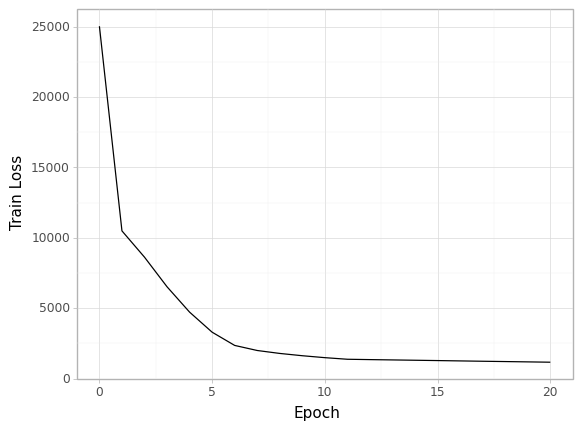

<ggplot: (8752746590919)>

In [13]:
(
    ggplot(train_scores, aes(x='Epoch', y='Train loss'))
        + geom_line(color='black') # line plot
        + labs(x='Epoch', y='Train Loss')
        + theme_light()
)

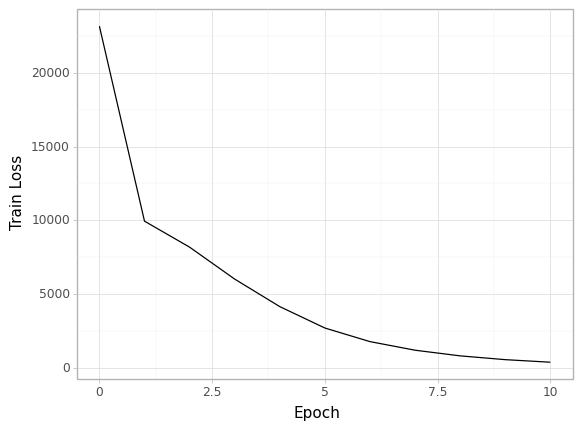

<ggplot: (8766212041117)>

In [13]:
(
    ggplot(train_scores, aes(x='Epoch', y='Train loss'))
        + geom_line(color='black') # line plot
        + labs(x='Epoch', y='Train Loss')
        + theme_light()
)

In [11]:
valid_scores = pd.DataFrame(np.hstack([(range(0, cfg.epochs+1, cfg.check_epoch), total_logs[score], [score for i in range(0, cfg.epochs+1, cfg.check_epoch)]) for score in ['Valid Recall@25', 'Valid NDCG@25', 'Valid Coverage', 'Valid Score']])).T
valid_scores.columns = ['Epoch', 'Score', 'Metric']
valid_scores['Epoch'] = valid_scores['Epoch'].astype(int)
valid_scores['Score'] = valid_scores['Score'].astype(float)

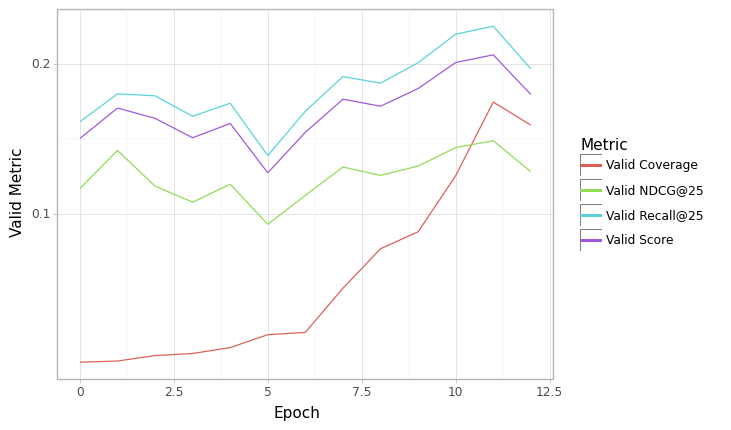

<ggplot: (8783353691642)>

In [12]:
(
ggplot(valid_scores)  # here
    + aes("Epoch", "Score", color='Metric', group='Metric')
    + geom_line()
    + scale_y_continuous(breaks=[0.1*c for c in range(1, 10, 1)])
    + theme_light()
    + labs(x='Epoch', y='Valid Metric')
)  

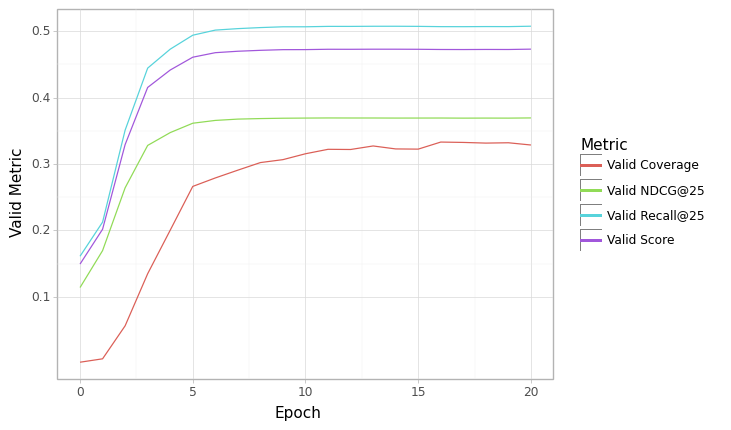

<ggplot: (8752741262318)>

In [15]:
(
ggplot(valid_scores)  # here
    + aes("Epoch", "Score", color='Metric', group='Metric')
    + geom_line()
    + scale_y_continuous(breaks=[0.1*c for c in range(1, 10, 1)])
    + theme_light()
    + labs(x='Epoch', y='Valid Metric')
)  

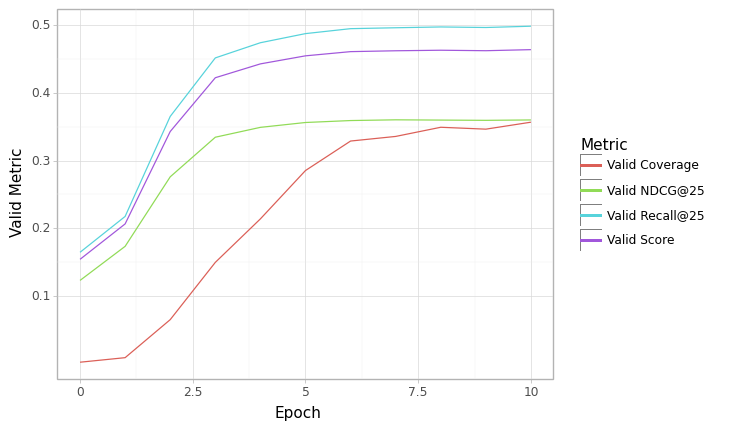

<ggplot: (8766212029931)>

In [15]:
(
ggplot(valid_scores)  # here
    + aes("Epoch", "Score", color='Metric', group='Metric')
    + geom_line()
    + scale_y_continuous(breaks=[0.1*c for c in range(1, 10, 1)])
    + theme_light()
    + labs(x='Epoch', y='Valid Metric')
)  

## 제출 
### 모든 유저에 대해 추천 결과 생성

In [13]:
model.load_state_dict(torch.load(os.path.join(saved_path, 'model(deep_wide_+feat_neg125_drop01_reg01).pth')))

<All keys matched successfully>

In [14]:
submission_path = os.path.join(data_path, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission = valid_epoch(cfg, model, submission, mode='test')

100%|██████████| 8311/8311 [01:27<00:00, 94.53it/s]


### 저장

In [15]:
submission.to_csv(os.path.join(output_path, 'model(deep_wide_+feat_neg125_drop01_reg01).csv'), index = False)